In [1]:
!unzip -q "/content/dataset-1.0.zip" -d "/content/cwfid"

In [2]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import yaml
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision import transforms
from tqdm import tqdm
import torchvision.transforms as T
from glob import glob
from PIL import Image
from albumentations.pytorch import ToTensorV2
import albumentations as A
import cv2

In [3]:
base_dir= "/content/cwfid/dataset-1.0"
print(os.listdir(base_dir))

['train_test_split.yaml', 'README.md', 'images', 'masks', 'annotations']


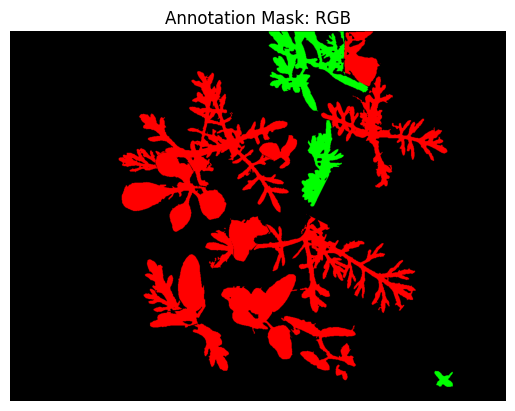

Unique RGB colors in annotation: [[  0   0   0]
 [  0 255   0]
 [255   0   0]]


In [4]:
# load sample annotation and convert to arr
ann_path= '/content/cwfid/dataset-1.0/annotations/001_annotation.png'
ann= Image.open(ann_path).convert('RGB')
ann_np= np.array(ann)

plt.imshow(ann)
plt.title('Annotation Mask: RGB')
plt.axis('off')
plt.show()

# unique RGB values
unique_colors= np.unique(ann_np.reshape(-1, 3), axis=0)
print("Unique RGB colors in annotation:", unique_colors)


In [5]:
src_folder= "/content/cwfid/dataset-1.0/annotations"
dest_folder= "/content/cwfid/converted_masks"
os.makedirs(dest_folder, exist_ok= True)

def generate_masks(annotation_path): # this function maps annotations to label maps (0,1,2) for bg, weed, and crop
  rgb= np.array(Image.open(annotation_path).convert('RGB'))
  mask= np.zeros(rgb.shape[:2], dtype= np.uint8)
  mask[np.all(rgb == [0, 255, 0], axis=-1)]= 1  # crop
  mask[np.all(rgb == [255, 0, 0], axis=-1)]= 2  # weed
  return mask

# batch processing
for fname in os.listdir(src_folder):
    if fname.endswith('.png'):
        path = os.path.join(src_folder, fname)
        class_mask = generate_masks(path)
        out_path = os.path.join(dest_folder, fname.replace('_annotation', '_classmask'))
        Image.fromarray(class_mask).save(out_path)

In [6]:
# paths
img_dir= '/content/cwfid/dataset-1.0/images'
mask_dir= '/content/cwfid/converted_masks'
aug_img_dir= '/content/cwfid/augmented/images'
aug_mask_dir= '/content/cwfid/augmented/masks'
os.makedirs(aug_img_dir, exist_ok=True)
os.makedirs(aug_mask_dir, exist_ok=True)

# augmentations
augment= A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=20, p=0.5),
    A.GaussianBlur(p=0.2),
], additional_targets={'mask': 'mask'})

# 3 augmentations per image
num_augments= 3

for fname in sorted(os.listdir(img_dir)):
    if not fname.endswith('.png'):
        continue

    # loading image and mask
    img_path= os.path.join(img_dir, fname)
    mask_path= os.path.join(mask_dir, fname.replace('_image', '_classmask'))

    image= np.array(Image.open(img_path))
    mask= np.array(Image.open(mask_path))

    for i in range(num_augments):
        augmented= augment(image=image, mask=mask)
        aug_img= augmented['image']
        aug_mask= augmented['mask']

        base_name= fname.replace('_image.png', '')
        Image.fromarray(aug_img).save(f'{aug_img_dir}/{base_name}_aug{i}.png')
        Image.fromarray(aug_mask).save(f'{aug_mask_dir}/{base_name}_aug{i}.png')


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [7]:
yaml_path = '/content/cwfid/dataset-1.0/train_test_split.yaml'

with open(yaml_path, 'r') as f:
    split = yaml.safe_load(f)

print("YAML keys:", list(split.keys()))

print(f"\nTrain set: {len(split['train'])} samples")
print(f"Test set: {len(split['test'])} samples")

print("\nSample train entries:", split['train'][:5])
print("Sample test entries:", split['test'][:5])


YAML keys: ['train', 'test']

Train set: 40 samples
Test set: 21 samples

Sample train entries: [2, 5, 6, 7, 8]
Sample test entries: [1, 3, 4, 9, 10]


In [8]:
# Paths
root = "/content/cwfid/dataset-1.0"
old_yaml_path = os.path.join(root, "train_test_split.yaml")
new_yaml_path = os.path.join(root, "train_test_augmented.yaml")

# Load old ID-based split
with open(old_yaml_path, 'r') as f:
    split_ids = yaml.safe_load(f)

# Convert integer IDs to full filenames
def format_filename(id, suffix, ext=".png"):
    return f"{int(id):03d}_{suffix}{ext}"

# Build original filename lists
train_files = [format_filename(i, "image") for i in split_ids["train"]]
test_files = [format_filename(i, "image") for i in split_ids["test"]]

# Add augmented files to train split (e.g. 002_image_aug0.png)
image_dir = os.path.join(root, "images")
augmented_files = sorted(glob(os.path.join(image_dir, "*_aug*.png")))
augmented_filenames = [os.path.basename(f) for f in augmented_files if "_image" in f]

# Combine original + augmented
full_train = train_files + augmented_filenames

# Save new YAML with filename-based entries
new_split = {"train": full_train, "test": test_files}
with open(new_yaml_path, 'w') as f:
    yaml.dump(new_split, f)

print(f"New YAML saved to: {new_yaml_path}")
print(f"Train: {len(full_train)} images | Test: {len(test_files)} images")


New YAML saved to: /content/cwfid/dataset-1.0/train_test_augmented.yaml
Train: 40 images | Test: 21 images


In [9]:
COLOR_MAP= {
    (0, 0, 0): 0,       # Background
    (0, 255, 0): 1,     # Crop
    (255, 0, 0): 2      # Weed
}

class WeedSegDataset(Dataset):
  def __init__(self, image_dir, mask_dir, file_list, transform= None):
    self.image_dir= image_dir
    self.mask_dir= mask_dir
    self.file_list= file_list
    self.transform= transform

  def __len__(self):
    return len(self.file_list)

  def __getitem__(self, idx):
    image_name= self.file_list[idx]
    mask_name= image_name.replace('image', 'mask')

    # load image and mask
    image_path= os.path.join(self.image_dir, image_name)
    mask_path= os.path.join(self.mask_dir, mask_name)

    image= Image.open(image_path).convert('RGB')
    mask= Image.open(mask_path).convert('RGB')  # still RGB before mapping

    # map mask to id
    mask_np= np.array(mask)
    mask_class= np.zeros(mask_np.shape[:2], dtype= np.uint8)
    for rgb, class_id in COLOR_MAP.items():
      match= np.all(mask_np == rgb, axis= -1)
      mask_class[match]= class_id

    if self.transform:
      image= self.transform(image)
      mask_class= torch.tensor(mask_class, dtype= torch.long)

    return image, mask_class


In [10]:
image_dir= "/content/cwfid/dataset-1.0/images"
mask_dir= "/content/cwfid/dataset-1.0/masks"
train_files= new_split["train"]
test_files= new_split["test"]

# transforms
transform= Compose([
    ToTensor(),
    Normalize(mean=[0.5]*3, std=[0.5]*3)  # normalize to [-1,1]
])

train_dataset= WeedSegDataset(image_dir, mask_dir, train_files, transform)
test_dataset= WeedSegDataset(image_dir, mask_dir, test_files, transform)

# Dataloaders
train_loader= DataLoader(train_dataset, batch_size=4, shuffle= True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle= False)

## Code Not Working

In [23]:
class FewShotSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, episodes=1000, k_shot=1, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.k_shot = k_shot
        self.episodes = episodes
        self.transform = transform

        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
        self.mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])

        assert len(self.image_files) == len(self.mask_files), "Mismatch in image/mask files"

        self.class_map = {
            0: 'background',
            1: 'crop',
            2: 'weed'
        }

    def __len__(self):
        return self.episodes

    def __getitem__(self, idx):
        for class_id in random.sample([1, 2], 2):  # Try weed first, fallback to crop
            valid_indices = []
            for i, mname in enumerate(self.mask_files):
                mask_path = os.path.join(self.mask_dir, mname)
                mask = np.array(Image.open(mask_path))
                if class_id in mask:
                    valid_indices.append(i)

            if len(valid_indices) >= self.k_shot + 1:
                break
        else:
            raise ValueError("Not enough samples for any class.")

        selected = random.sample(valid_indices, self.k_shot + 1)
        support_idx = selected[:self.k_shot]
        query_idx = selected[self.k_shot]

        def load_pair(idx):
            img = Image.open(os.path.join(self.image_dir, self.image_files[idx])).convert('RGB')
            mask = np.array(Image.open(os.path.join(self.mask_dir, self.mask_files[idx])))
            binary_mask = (mask == class_id).astype(np.uint8)
            if self.transform:
                img = self.transform(img)
                binary_mask = T.ToTensor()(binary_mask)
            return img, binary_mask

        support_set = [load_pair(i) for i in support_idx]
        query_img, query_mask = load_pair(query_idx)

        return support_set, (query_img, query_mask), class_id


In [25]:
class Encoder(nn.Module):
    def __init__(self, pretrained=True):
        super(Encoder, self).__init__()
        resnet = models.resnet18(pretrained=pretrained)
        # Remove final classification layers
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])

    def forward(self, x):
        return self.encoder(x)  # Feature map

In [31]:
def get_prototype(features, masks):
    B, C, H, W = features.shape

    # Resize masks to match feature map size
    masks = F.interpolate(masks.float(), size=(H, W), mode='bilinear', align_corners=False)

    masks = masks.expand(-1, C, -1, -1)  # (B, C, H, W)
    masked_feats = features * masks      # Element-wise masking
    sum_feats = masked_feats.view(B, C, -1).sum(dim=2)
    pixel_counts = masks.view(B, C, -1).sum(dim=2) + 1e-5  # prevent division by 0
    prototype = sum_feats / pixel_counts
    prototype = prototype.mean(dim=0)  # Average across K support images
    return prototype  # (C,)


def cosine_similarity(feature_map, prototype):
    B, C, H, W = feature_map.shape
    prototype = prototype.view(1, C, 1, 1)  # Reshape
    sim = torch.nn.functional.cosine_similarity(feature_map, prototype, dim=1)
    return sim.unsqueeze(1)  # Add channel dim

class FewShotSegmentor(nn.Module):
    def __init__(self):
        super(FewShotSegmentor, self).__init__()
        self.encoder = Encoder()

    def forward(self, support_imgs, support_masks, query_img):
        # Encode support
        support_feats = [self.encoder(img.unsqueeze(0)) for img in support_imgs]
        support_masks = [mask.unsqueeze(0) for mask in support_masks]

        support_feats = torch.cat(support_feats, dim=0)  # (K, C, H, W)
        support_masks = torch.cat(support_masks, dim=0)  # (K, 1, H, W)

        # Generate prototype
        prototype = get_prototype(support_feats, support_masks)

        # Encode query
        query_feat = self.encoder(query_img.unsqueeze(0))  # (1, C, H, W)

        # Similarity map
        sim_map = cosine_similarity(query_feat, prototype)  # (1, 1, H, W)
        return sim_map


In [39]:
# training loop
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion= nn.BCEWithLogitsLoss()
model= FewShotSegmentor().to(device)
optimizer= torch.optim.Adam(model.parameters(), lr=1e-4)

def sample_episode(images, masks, K= 1):
    indices = list(range(len(images)))
    random.shuffle(indices)

    support_idxs = indices[:K]
    query_idx = indices[K]

    support_imgs = [images[i] for i in support_idxs]
    support_masks = [masks[i] for i in support_idxs]

    query_img = images[query_idx]
    query_mask = masks[query_idx]

    print("Support mask sum:", [mask.sum().item() for mask in support_masks])


    return support_imgs, support_masks, query_img, query_mask



def train(model, images, masks, epochs=10, episodes_per_epoch=20, K=1):
    model.train()

    for epoch in range(epochs):
        epoch_loss = 0.0

        for _ in tqdm(range(episodes_per_epoch), desc=f"Epoch {epoch+1}/{epochs}"):
            support_imgs, support_masks, query_img, query_mask = sample_episode(images, masks, K)

            # Move to device
            support_imgs = [img.to(device) for img in support_imgs]
            support_masks = [mask.to(device) for mask in support_masks]
            query_img = query_img.to(device)
            query_mask = query_mask.to(device)

            # Forward pass
            output = model(support_imgs, support_masks, query_img)  # (1, 1, H, W)

            # Resize ground truth if needed
            query_mask = F.interpolate(query_mask.unsqueeze(0), size=output.shape[-2:], mode='bilinear', align_corners=False)

            # Loss
            loss = criterion(output, query_mask)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch+1} Loss: {epoch_loss / episodes_per_epoch:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [48]:
test_dataset = FewShotSegmentationDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    episodes=5,  # how many test episodes to sample
    k_shot=1,
    transform=transform
)


In [49]:
from sklearn.metrics import jaccard_score, f1_score

from sklearn.metrics import jaccard_score, f1_score

def evaluate(model, dataset, device, episodes=10, K=1):
    model.eval()
    ious = []
    dices = []

    for _ in range(episodes):
        support_set, (query_img, query_mask), class_id = dataset[random.randint(0, len(dataset)-1)]
        support_imgs, support_masks = zip(*support_set)

        support_imgs = [img.to(device) for img in support_imgs]
        support_masks = [mask.to(device) for mask in support_masks]
        query_img = query_img.to(device)
        query_mask = query_mask.to(device)

        with torch.no_grad():
            pred = model(support_imgs, support_masks, query_img)
            pred = torch.sigmoid(pred)  # convert logits to probabilities
            pred_bin = (pred > 0.5).float()  # threshold at 0.5

        # Resize masks to match pred size
        query_mask_resized = F.interpolate(query_mask.unsqueeze(0), size=pred.shape[-2:], mode='bilinear', align_corners=False)
        query_mask_bin = (query_mask_resized > 0.5).float()  # binarize GT

        y_true = query_mask_bin.view(-1).cpu().numpy()
        y_pred = pred_bin.view(-1).cpu().numpy()

        if y_true.sum() == 0 and y_pred.sum() == 0:
            continue  # skip empty masks

        iou = jaccard_score(y_true, y_pred)
        dice = f1_score(y_true, y_pred)
        ious.append(iou)
        dices.append(dice)

    return {
        "mean_iou": np.mean(ious),
        "mean_dice": np.mean(dices)
    }



In [42]:
results = evaluate(model, test_dataset, device=device)
print("Mean IoU:", results["mean_iou"])
print("Mean Dice:", results["mean_dice"])

Mean IoU: 0.0
Mean Dice: 0.0


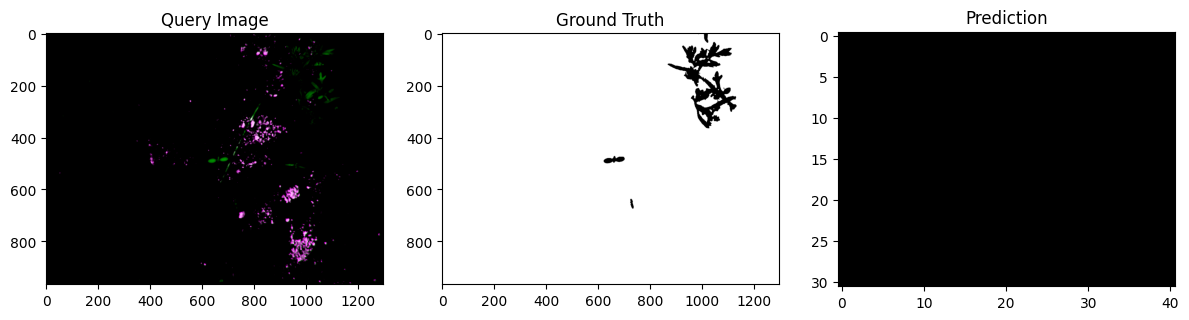

In [43]:
def visualize_episode(model, dataset, idx=0):
    model.eval()
    with torch.no_grad():
        support_set, (query_img, query_mask), class_id = dataset[idx]
        support_imgs = [img.to(device) for img, _ in support_set]
        support_masks = [mask.to(device) for _, mask in support_set]
        query_img = query_img.to(device)

        pred = model(support_imgs, support_masks, query_img)
        pred = torch.sigmoid(pred)
        pred_bin = (pred > 0.5).float()

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(query_img.cpu().permute(1, 2, 0).numpy())
        plt.title("Query Image")

        plt.subplot(1, 3, 2)
        plt.imshow(query_mask.squeeze().cpu(), cmap="gray")
        plt.title("Ground Truth")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_bin.squeeze().cpu(), cmap="gray")
        plt.title("Prediction")

        plt.tight_layout()
        plt.show()
visualize_episode(model, test_dataset, idx=0)
